In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
%%bash
pip install tqdm
pip install --upgrade torch
pip install numpy
pip install matplotlib

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.6.0)


You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [9]:
import os

import torch
import torchvision

from data_utils import cifar10, cifar10_classes, matplotlib_imshow, plot_history
from train_utils import train, evaluate, device
from models.mlp import MLP

In [4]:
HPS = dict(
    batch_size=128,
    epochs=50,
)

model_dir = './models/cifar10_custom_resnet'

train_ds, test_ds = cifar10(batch_size=HPS['batch_size'])

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
import torch
import torch.nn as nn
from torchvision.models.utils import load_state_dict_from_url


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
#         x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

# Custom added
def resnet9(pretrained=False, progress=True, **kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet9', BasicBlock, [1, 1, 1, 1], pretrained, progress,
                   **kwargs)

def resnet18(pretrained=False, progress=True, **kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)


def resnet34(pretrained=False, progress=True, **kwargs):
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet50(pretrained=False, progress=True, **kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet101(pretrained=False, progress=True, **kwargs):
    r"""ResNet-101 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet101', Bottleneck, [3, 4, 23, 3], pretrained, progress,
                   **kwargs)


def resnet152(pretrained=False, progress=True, **kwargs):
    r"""ResNet-152 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet152', Bottleneck, [3, 8, 36, 3], pretrained, progress,
                   **kwargs)


def resnext50_32x4d(pretrained=False, progress=True, **kwargs):
    r"""ResNeXt-50 32x4d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 4
    return _resnet('resnext50_32x4d', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def resnext101_32x8d(pretrained=False, progress=True, **kwargs):
    r"""ResNeXt-101 32x8d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 8
    return _resnet('resnext101_32x8d', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)


def wide_resnet50_2(pretrained=False, progress=True, **kwargs):
    r"""Wide ResNet-50-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_
    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet50_2', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def wide_resnet101_2(pretrained=False, progress=True, **kwargs):
    r"""Wide ResNet-101-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_
    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet101_2', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)

In [18]:
model = resnet18(num_classes=10, zero_init_residual=True)

In [19]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[25, 40], gamma=0.1)
history = train(train_ds, test_ds, optimizer, model, scheduler=scheduler, epochs=HPS['epochs'])
torch.save({
    'model_state_dict': model.state_dict(),
    'opt_state_dict': optimizer.state_dict(),
    'history': history
}, model_dir)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0: Loss: 1.7538173256627738 Batch Accuracy: 0.34204


  2%|▏         | 1/50 [00:50<40:50, 50.00s/it]

Test Set evaluation: Loss: 1.4275762295421166 Test Accuracy: 0.4725
Epoch 1: Loss: 1.2989544685539383 Batch Accuracy: 0.5229


  4%|▍         | 2/50 [01:41<40:23, 50.48s/it]

Test Set evaluation: Loss: 1.1963112754157827 Test Accuracy: 0.5748
Epoch 2: Loss: 1.0053520780390182 Batch Accuracy: 0.63848


  6%|▌         | 3/50 [02:32<39:34, 50.52s/it]

Test Set evaluation: Loss: 0.9582431716254994 Test Accuracy: 0.6684
Epoch 3: Loss: 0.8117035924626128 Batch Accuracy: 0.71498


  8%|▊         | 4/50 [03:24<39:02, 50.93s/it]

Test Set evaluation: Loss: 0.8300923229772833 Test Accuracy: 0.7095
Epoch 4: Loss: 0.6848032716899881 Batch Accuracy: 0.75976


 10%|█         | 5/50 [04:14<38:04, 50.77s/it]

Test Set evaluation: Loss: 0.8435894895957995 Test Accuracy: 0.7158
Epoch 5: Loss: 0.6018538149573919 Batch Accuracy: 0.79118


 12%|█▏        | 6/50 [05:06<37:27, 51.07s/it]

Test Set evaluation: Loss: 0.655114742396753 Test Accuracy: 0.7766
Epoch 6: Loss: 0.5387249505885726 Batch Accuracy: 0.81466


 14%|█▍        | 7/50 [05:57<36:39, 51.16s/it]

Test Set evaluation: Loss: 0.6164043375962898 Test Accuracy: 0.7886
Epoch 7: Loss: 0.4890608366035744 Batch Accuracy: 0.8317


 16%|█▌        | 8/50 [06:48<35:48, 51.16s/it]

Test Set evaluation: Loss: 0.5427857475190223 Test Accuracy: 0.8195
Epoch 8: Loss: 0.45650434097670534 Batch Accuracy: 0.84114


 18%|█▊        | 9/50 [07:40<35:07, 51.40s/it]

Test Set evaluation: Loss: 0.4899102426782439 Test Accuracy: 0.8317
Epoch 9: Loss: 0.4244931630999841 Batch Accuracy: 0.85438


 20%|██        | 10/50 [08:31<34:09, 51.23s/it]

Test Set evaluation: Loss: 0.5688207285313667 Test Accuracy: 0.8026
Epoch 10: Loss: 0.4040841365714207 Batch Accuracy: 0.86196


 22%|██▏       | 11/50 [09:22<33:16, 51.18s/it]

Test Set evaluation: Loss: 0.4504305146917512 Test Accuracy: 0.8473
Epoch 11: Loss: 0.3822519499856188 Batch Accuracy: 0.86762


 24%|██▍       | 12/50 [10:14<32:27, 51.25s/it]

Test Set evaluation: Loss: 0.5255672245085994 Test Accuracy: 0.8292
Epoch 12: Loss: 0.36711816516373774 Batch Accuracy: 0.87436


 26%|██▌       | 13/50 [11:04<31:31, 51.12s/it]

Test Set evaluation: Loss: 0.5475673845297173 Test Accuracy: 0.8187
Epoch 13: Loss: 0.3543428705476434 Batch Accuracy: 0.87844


 28%|██▊       | 14/50 [11:56<30:40, 51.13s/it]

Test Set evaluation: Loss: 0.5287624308957329 Test Accuracy: 0.8319
Epoch 14: Loss: 0.34355927127249103 Batch Accuracy: 0.88176


 30%|███       | 15/50 [12:48<29:58, 51.39s/it]

Test Set evaluation: Loss: 0.5164183295225795 Test Accuracy: 0.8313
Epoch 15: Loss: 0.3323901127976225 Batch Accuracy: 0.88506


 32%|███▏      | 16/50 [13:39<29:03, 51.29s/it]

Test Set evaluation: Loss: 0.45658827544767644 Test Accuracy: 0.8469
Epoch 16: Loss: 0.3206656807295197 Batch Accuracy: 0.89048


 34%|███▍      | 17/50 [14:30<28:13, 51.31s/it]

Test Set evaluation: Loss: 0.5179351836065703 Test Accuracy: 0.8299
Epoch 17: Loss: 0.31248726187002324 Batch Accuracy: 0.89278


 36%|███▌      | 18/50 [15:20<27:14, 51.08s/it]

Test Set evaluation: Loss: 0.42690291548077064 Test Accuracy: 0.8533
Epoch 18: Loss: 0.3051983140542379 Batch Accuracy: 0.89454


 38%|███▊      | 19/50 [16:12<26:27, 51.22s/it]

Test Set evaluation: Loss: 0.43184298767319207 Test Accuracy: 0.8619
Epoch 19: Loss: 0.3006655822324631 Batch Accuracy: 0.89528


 40%|████      | 20/50 [17:03<25:30, 51.02s/it]

Test Set evaluation: Loss: 0.48629611692851105 Test Accuracy: 0.8458
Epoch 20: Loss: 0.2925227373609762 Batch Accuracy: 0.89862


 42%|████▏     | 21/50 [17:58<25:19, 52.39s/it]

Test Set evaluation: Loss: 0.5218040935600861 Test Accuracy: 0.833
Epoch 21: Loss: 0.2871566411403134 Batch Accuracy: 0.9012


 44%|████▍     | 22/50 [18:55<25:05, 53.77s/it]

Test Set evaluation: Loss: 0.45258520967975446 Test Accuracy: 0.8554
Epoch 22: Loss: 0.28009202426580515 Batch Accuracy: 0.90248


 46%|████▌     | 23/50 [19:47<23:57, 53.23s/it]

Test Set evaluation: Loss: 0.39893190921107424 Test Accuracy: 0.866
Epoch 23: Loss: 0.2760575013925962 Batch Accuracy: 0.9047


 48%|████▊     | 24/50 [20:37<22:37, 52.23s/it]

Test Set evaluation: Loss: 0.4362639069934435 Test Accuracy: 0.8576
Epoch 24: Loss: 0.26825744022265113 Batch Accuracy: 0.90756


 50%|█████     | 25/50 [21:29<21:41, 52.05s/it]

Test Set evaluation: Loss: 0.4739775316247457 Test Accuracy: 0.8455
Epoch 25: Loss: 0.14735408826633487 Batch Accuracy: 0.95104


 52%|█████▏    | 26/50 [22:20<20:42, 51.77s/it]

Test Set evaluation: Loss: 0.22356158702433865 Test Accuracy: 0.9236
Epoch 26: Loss: 0.10720721624620125 Batch Accuracy: 0.9646


 54%|█████▍    | 27/50 [23:12<19:52, 51.84s/it]

Test Set evaluation: Loss: 0.21630240948517113 Test Accuracy: 0.9251
Epoch 27: Loss: 0.09264172619813696 Batch Accuracy: 0.9688


 56%|█████▌    | 28/50 [24:04<18:59, 51.81s/it]

Test Set evaluation: Loss: 0.22138569711507122 Test Accuracy: 0.9273
Epoch 28: Loss: 0.08537704858195294 Batch Accuracy: 0.9722


 58%|█████▊    | 29/50 [24:55<18:03, 51.59s/it]

Test Set evaluation: Loss: 0.22301889729650715 Test Accuracy: 0.9272
Epoch 29: Loss: 0.07477373264425094 Batch Accuracy: 0.9752


 60%|██████    | 30/50 [25:46<17:09, 51.48s/it]

Test Set evaluation: Loss: 0.2208337804561929 Test Accuracy: 0.9278
Epoch 30: Loss: 0.06709982919247101 Batch Accuracy: 0.97818


 62%|██████▏   | 31/50 [26:36<16:13, 51.23s/it]

Test Set evaluation: Loss: 0.224309417926058 Test Accuracy: 0.9304
Epoch 31: Loss: 0.06074106051107807 Batch Accuracy: 0.97974


 64%|██████▍   | 32/50 [27:28<15:21, 51.19s/it]

Test Set evaluation: Loss: 0.23118809374827373 Test Accuracy: 0.9296
Epoch 32: Loss: 0.05584979408642139 Batch Accuracy: 0.98182


 66%|██████▌   | 33/50 [28:19<14:30, 51.22s/it]

Test Set evaluation: Loss: 0.23613176636303526 Test Accuracy: 0.9287
Epoch 33: Loss: 0.05082366930897279 Batch Accuracy: 0.98356


 68%|██████▊   | 34/50 [29:11<13:43, 51.49s/it]

Test Set evaluation: Loss: 0.23605398296178143 Test Accuracy: 0.9301
Epoch 34: Loss: 0.04607647520197017 Batch Accuracy: 0.98532


 70%|███████   | 35/50 [30:02<12:50, 51.40s/it]

Test Set evaluation: Loss: 0.2397931295482418 Test Accuracy: 0.93
Epoch 35: Loss: 0.042975453360963735 Batch Accuracy: 0.98648


 72%|███████▏  | 36/50 [30:55<12:04, 51.77s/it]

Test Set evaluation: Loss: 0.23974532662313194 Test Accuracy: 0.9327
Epoch 36: Loss: 0.04150333629963953 Batch Accuracy: 0.98598


 74%|███████▍  | 37/50 [31:47<11:13, 51.78s/it]

Test Set evaluation: Loss: 0.24374684436789043 Test Accuracy: 0.9281
Epoch 37: Loss: 0.03577223038443786 Batch Accuracy: 0.98856


 76%|███████▌  | 38/50 [32:39<10:22, 51.85s/it]

Test Set evaluation: Loss: 0.25440632853704165 Test Accuracy: 0.9306
Epoch 38: Loss: 0.034380006493138306 Batch Accuracy: 0.98906


 78%|███████▊  | 39/50 [33:29<09:27, 51.55s/it]

Test Set evaluation: Loss: 0.25385011091262477 Test Accuracy: 0.9276
Epoch 39: Loss: 0.03190028208457982 Batch Accuracy: 0.99022


 80%|████████  | 40/50 [34:22<08:38, 51.82s/it]

Test Set evaluation: Loss: 0.25902463618335847 Test Accuracy: 0.9301
Epoch 40: Loss: 0.024193698128261377 Batch Accuracy: 0.99298


 82%|████████▏ | 41/50 [35:42<09:02, 60.30s/it]

Test Set evaluation: Loss: 0.24523458276179771 Test Accuracy: 0.9314
Epoch 41: Loss: 0.020277326565135815 Batch Accuracy: 0.99444


 84%|████████▍ | 42/50 [37:03<08:51, 66.49s/it]

Test Set evaluation: Loss: 0.24300212785601616 Test Accuracy: 0.9328
Epoch 42: Loss: 0.020014193174584062 Batch Accuracy: 0.9946


 86%|████████▌ | 43/50 [38:24<08:15, 70.74s/it]

Test Set evaluation: Loss: 0.24268414796907692 Test Accuracy: 0.9337
Epoch 43: Loss: 0.019077582951442188 Batch Accuracy: 0.99476


 88%|████████▊ | 44/50 [39:44<07:22, 73.69s/it]

Test Set evaluation: Loss: 0.24157631755629672 Test Accuracy: 0.9345
Epoch 44: Loss: 0.017886994134448945 Batch Accuracy: 0.9954


 90%|█████████ | 45/50 [41:05<06:19, 75.92s/it]

Test Set evaluation: Loss: 0.24353357083812543 Test Accuracy: 0.9333
Epoch 45: Loss: 0.01744746431634497 Batch Accuracy: 0.9954


 92%|█████████▏| 46/50 [42:26<05:09, 77.29s/it]

Test Set evaluation: Loss: 0.2456820952364161 Test Accuracy: 0.9331
Epoch 46: Loss: 0.017035247436474502 Batch Accuracy: 0.99572


 94%|█████████▍| 47/50 [43:47<03:55, 78.54s/it]

Test Set evaluation: Loss: 0.24183425250687177 Test Accuracy: 0.9338
Epoch 47: Loss: 0.015888534776290018 Batch Accuracy: 0.9961


 96%|█████████▌| 48/50 [45:09<02:38, 79.41s/it]

Test Set evaluation: Loss: 0.24250886825066578 Test Accuracy: 0.9342
Epoch 48: Loss: 0.01584761631925164 Batch Accuracy: 0.99622


 98%|█████████▊| 49/50 [46:30<01:19, 79.86s/it]

Test Set evaluation: Loss: 0.24583892165860044 Test Accuracy: 0.9331
Epoch 49: Loss: 0.015083877407276378 Batch Accuracy: 0.99632


100%|██████████| 50/50 [47:50<00:00, 57.41s/it]

Test Set evaluation: Loss: 0.2459413333784176 Test Accuracy: 0.9342


Test Set evaluation: Loss: 0.2459413333784176 Test Accuracy: 0.9342


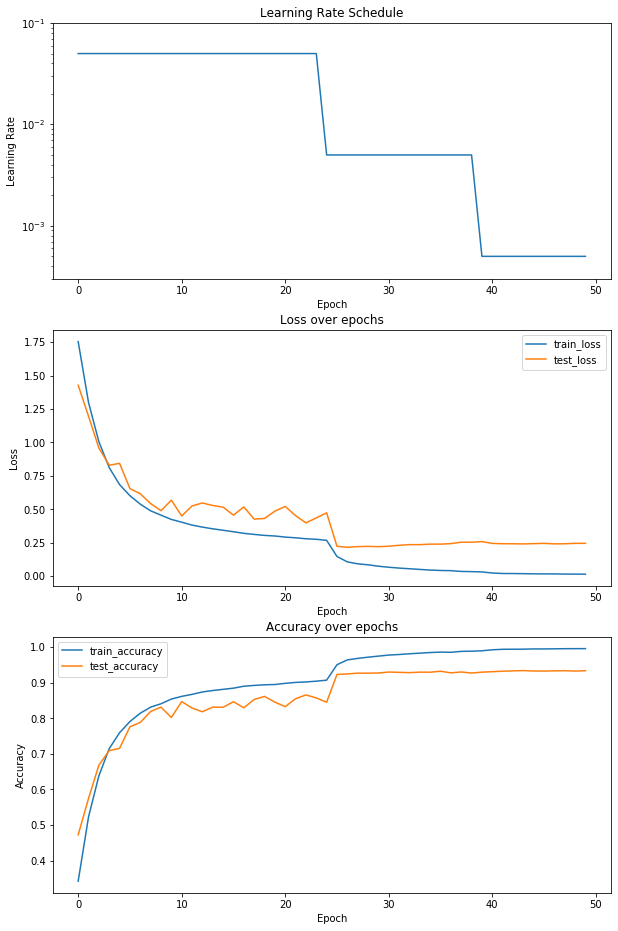

In [20]:
checkpoint = torch.load(model_dir)
r18 = resnet18(num_classes=10, zero_init_residual=True)
r18.to(device)
r18.load_state_dict(checkpoint['model_state_dict'])
evaluate(test_ds, r18, nn.CrossEntropyLoss())
plot_history(checkpoint['history'])

In [16]:
model = resnet9(num_classes=10, zero_init_residual=True)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[25, 40], gamma=0.1)
history = train(train_ds, test_ds, optimizer, model, scheduler=scheduler, epochs=HPS['epochs'])
torch.save({
    'model_state_dict': model.state_dict(),
    'opt_state_dict': optimizer.state_dict(),
    'history': history
}, f'{model_dir}_resnet9')

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0: Loss: 1.7990354622721367 Batch Accuracy: 0.32254


  2%|▏         | 1/50 [00:37<30:43, 37.62s/it]

Test Set evaluation: Loss: 1.5245963576473767 Test Accuracy: 0.4279
Epoch 1: Loss: 1.3974035399039384 Batch Accuracy: 0.48394


  4%|▍         | 2/50 [01:16<30:20, 37.93s/it]

Test Set evaluation: Loss: 1.2305199594437322 Test Accuracy: 0.5492
Epoch 2: Loss: 1.106856496132853 Batch Accuracy: 0.59766


  6%|▌         | 3/50 [01:54<29:42, 37.93s/it]

Test Set evaluation: Loss: 1.26589835595481 Test Accuracy: 0.5921
Epoch 3: Loss: 0.9330380647383687 Batch Accuracy: 0.66716


  8%|▊         | 4/50 [02:31<29:01, 37.85s/it]

Test Set evaluation: Loss: 1.0007430986513066 Test Accuracy: 0.6617
Epoch 4: Loss: 0.8105714946146816 Batch Accuracy: 0.71292


 10%|█         | 5/50 [03:10<28:28, 37.96s/it]

Test Set evaluation: Loss: 0.9344036254701735 Test Accuracy: 0.69
Epoch 5: Loss: 0.7157869958664145 Batch Accuracy: 0.74852


 12%|█▏        | 6/50 [03:47<27:40, 37.73s/it]

Test Set evaluation: Loss: 0.69611624675461 Test Accuracy: 0.7532
Epoch 6: Loss: 0.632057290247944 Batch Accuracy: 0.77948


 14%|█▍        | 7/50 [04:25<27:04, 37.78s/it]

Test Set evaluation: Loss: 0.7945392659947842 Test Accuracy: 0.7424
Epoch 7: Loss: 0.5777156382722928 Batch Accuracy: 0.80078


 16%|█▌        | 8/50 [05:01<26:13, 37.47s/it]

Test Set evaluation: Loss: 0.6979860101319566 Test Accuracy: 0.7639
Epoch 8: Loss: 0.5297094468417984 Batch Accuracy: 0.81666


 18%|█▊        | 9/50 [05:40<25:44, 37.67s/it]

Test Set evaluation: Loss: 0.6644362841225877 Test Accuracy: 0.7748
Epoch 9: Loss: 0.4967057378700627 Batch Accuracy: 0.8282


 20%|██        | 10/50 [06:17<25:04, 37.61s/it]

Test Set evaluation: Loss: 0.6817540292498432 Test Accuracy: 0.7838
Epoch 10: Loss: 0.4657280614308994 Batch Accuracy: 0.83954


 22%|██▏       | 11/50 [06:54<24:24, 37.56s/it]

Test Set evaluation: Loss: 0.523247711643388 Test Accuracy: 0.8212
Epoch 11: Loss: 0.4409369406340372 Batch Accuracy: 0.84938


 24%|██▍       | 12/50 [07:33<23:58, 37.87s/it]

Test Set evaluation: Loss: 0.619490601593935 Test Accuracy: 0.798
Epoch 12: Loss: 0.4162701762774411 Batch Accuracy: 0.85684


 26%|██▌       | 13/50 [08:11<23:20, 37.84s/it]

Test Set evaluation: Loss: 0.47571372005003915 Test Accuracy: 0.8358
Epoch 13: Loss: 0.3963219056958738 Batch Accuracy: 0.86352


 28%|██▊       | 14/50 [08:50<22:54, 38.19s/it]

Test Set evaluation: Loss: 0.5058493934854676 Test Accuracy: 0.8267
Epoch 14: Loss: 0.39157507593369545 Batch Accuracy: 0.8641


 30%|███       | 15/50 [09:28<22:16, 38.19s/it]

Test Set evaluation: Loss: 0.46809350425684 Test Accuracy: 0.8409
Epoch 15: Loss: 0.37608590866903513 Batch Accuracy: 0.8705


 32%|███▏      | 16/50 [10:05<21:30, 37.96s/it]

Test Set evaluation: Loss: 0.6612400469146197 Test Accuracy: 0.7905
Epoch 16: Loss: 0.3637159839844155 Batch Accuracy: 0.87486


 34%|███▍      | 17/50 [10:44<20:57, 38.09s/it]

Test Set evaluation: Loss: 0.5694427965562555 Test Accuracy: 0.8136
Epoch 17: Loss: 0.3526956056771071 Batch Accuracy: 0.8789


 36%|███▌      | 18/50 [11:22<20:18, 38.09s/it]

Test Set evaluation: Loss: 0.5998750212071817 Test Accuracy: 0.8129
Epoch 18: Loss: 0.3519311503833517 Batch Accuracy: 0.87706


 38%|███▊      | 19/50 [11:59<19:35, 37.92s/it]

Test Set evaluation: Loss: 0.4305487003507493 Test Accuracy: 0.858
Epoch 19: Loss: 0.33393100106045415 Batch Accuracy: 0.8846


 40%|████      | 20/50 [12:38<19:01, 38.06s/it]

Test Set evaluation: Loss: 0.4649215691451785 Test Accuracy: 0.849
Epoch 20: Loss: 0.32835619460286386 Batch Accuracy: 0.88716


 42%|████▏     | 21/50 [13:15<18:14, 37.73s/it]

Test Set evaluation: Loss: 0.517901213863228 Test Accuracy: 0.833
Epoch 21: Loss: 0.32626662992150585 Batch Accuracy: 0.8871


 44%|████▍     | 22/50 [13:52<17:29, 37.47s/it]

Test Set evaluation: Loss: 0.4404692276369167 Test Accuracy: 0.8542
Epoch 22: Loss: 0.31474329858942107 Batch Accuracy: 0.89186


 46%|████▌     | 23/50 [14:29<16:51, 37.46s/it]

Test Set evaluation: Loss: 0.5915686914437934 Test Accuracy: 0.8115
Epoch 23: Loss: 0.3107003290634936 Batch Accuracy: 0.89226


 48%|████▊     | 24/50 [15:07<16:20, 37.71s/it]

Test Set evaluation: Loss: 0.4909125319387339 Test Accuracy: 0.8405
Epoch 24: Loss: 0.30568292927559076 Batch Accuracy: 0.89438


 50%|█████     | 25/50 [15:45<15:42, 37.69s/it]

Test Set evaluation: Loss: 0.4868251820908317 Test Accuracy: 0.8501
Epoch 25: Loss: 0.19037651449746792 Batch Accuracy: 0.93774


 52%|█████▏    | 26/50 [16:23<15:08, 37.84s/it]

Test Set evaluation: Loss: 0.25507447194260885 Test Accuracy: 0.9136
Epoch 26: Loss: 0.15352569011699818 Batch Accuracy: 0.9488


 54%|█████▍    | 27/50 [17:02<14:35, 38.06s/it]

Test Set evaluation: Loss: 0.24321699373518366 Test Accuracy: 0.919
Epoch 27: Loss: 0.1366934133193377 Batch Accuracy: 0.95498


 56%|█████▌    | 28/50 [17:39<13:54, 37.94s/it]

Test Set evaluation: Loss: 0.24376356413092795 Test Accuracy: 0.918
Epoch 28: Loss: 0.12629886186869857 Batch Accuracy: 0.95926


 58%|█████▊    | 29/50 [18:17<13:17, 37.96s/it]

Test Set evaluation: Loss: 0.23793267944379698 Test Accuracy: 0.9214
Epoch 29: Loss: 0.11454590786334194 Batch Accuracy: 0.96284


 60%|██████    | 30/50 [18:55<12:33, 37.69s/it]

Test Set evaluation: Loss: 0.23773429363588744 Test Accuracy: 0.921
Epoch 30: Loss: 0.10854553669462423 Batch Accuracy: 0.9649


 62%|██████▏   | 31/50 [19:32<11:52, 37.50s/it]

Test Set evaluation: Loss: 0.24512960733492165 Test Accuracy: 0.9196
Epoch 31: Loss: 0.10191883547874668 Batch Accuracy: 0.96744


 64%|██████▍   | 32/50 [20:08<11:10, 37.27s/it]

Test Set evaluation: Loss: 0.2399919508378717 Test Accuracy: 0.9218
Epoch 32: Loss: 0.09578042027666746 Batch Accuracy: 0.96878


 66%|██████▌   | 33/50 [20:47<10:39, 37.62s/it]

Test Set evaluation: Loss: 0.24629904221318946 Test Accuracy: 0.9194
Epoch 33: Loss: 0.09174253762035114 Batch Accuracy: 0.97062


 68%|██████▊   | 34/50 [21:26<10:07, 37.98s/it]

Test Set evaluation: Loss: 0.24674019424975674 Test Accuracy: 0.9224
Epoch 34: Loss: 0.0855597657773196 Batch Accuracy: 0.97226


 70%|███████   | 35/50 [22:03<09:25, 37.67s/it]

Test Set evaluation: Loss: 0.24565853169070015 Test Accuracy: 0.9221
Epoch 35: Loss: 0.08006627379876116 Batch Accuracy: 0.97484


 72%|███████▏  | 36/50 [22:41<08:48, 37.76s/it]

Test Set evaluation: Loss: 0.25120076409812214 Test Accuracy: 0.9231
Epoch 36: Loss: 0.07621662446852688 Batch Accuracy: 0.9758


 74%|███████▍  | 37/50 [23:18<08:08, 37.60s/it]

Test Set evaluation: Loss: 0.24519806213771242 Test Accuracy: 0.9238
Epoch 37: Loss: 0.07321487341190466 Batch Accuracy: 0.97668


 76%|███████▌  | 38/50 [23:55<07:31, 37.60s/it]

Test Set evaluation: Loss: 0.24899269942241378 Test Accuracy: 0.9213
Epoch 38: Loss: 0.06667048405484317 Batch Accuracy: 0.97934


 78%|███████▊  | 39/50 [24:33<06:54, 37.70s/it]

Test Set evaluation: Loss: 0.24759007933773572 Test Accuracy: 0.9262
Epoch 39: Loss: 0.06615809489594167 Batch Accuracy: 0.97944


 80%|████████  | 40/50 [25:10<06:14, 37.49s/it]

Test Set evaluation: Loss: 0.2535456825943687 Test Accuracy: 0.9235
Epoch 40: Loss: 0.053238739838342534 Batch Accuracy: 0.98454


 82%|████████▏ | 41/50 [25:48<05:37, 37.48s/it]

Test Set evaluation: Loss: 0.24262497545797615 Test Accuracy: 0.927
Epoch 41: Loss: 0.049515293332297934 Batch Accuracy: 0.98618


 84%|████████▍ | 42/50 [26:25<05:00, 37.53s/it]

Test Set evaluation: Loss: 0.24359395911421958 Test Accuracy: 0.9291
Epoch 42: Loss: 0.04816066673801988 Batch Accuracy: 0.98672


 86%|████████▌ | 43/50 [27:03<04:23, 37.60s/it]

Test Set evaluation: Loss: 0.23894723877310753 Test Accuracy: 0.9286
Epoch 43: Loss: 0.04677960117969214 Batch Accuracy: 0.98772


 88%|████████▊ | 44/50 [27:40<03:44, 37.45s/it]

Test Set evaluation: Loss: 0.24002124288979965 Test Accuracy: 0.9285
Epoch 44: Loss: 0.045809869213825294 Batch Accuracy: 0.9882


 90%|█████████ | 45/50 [28:18<03:07, 37.52s/it]

Test Set evaluation: Loss: 0.24289316773603234 Test Accuracy: 0.9301
Epoch 45: Loss: 0.04409582005894702 Batch Accuracy: 0.9885


 92%|█████████▏| 46/50 [28:55<02:29, 37.44s/it]

Test Set evaluation: Loss: 0.2405159667700152 Test Accuracy: 0.9286
Epoch 46: Loss: 0.044186280516293044 Batch Accuracy: 0.98852


 94%|█████████▍| 47/50 [29:34<01:53, 37.73s/it]

Test Set evaluation: Loss: 0.24042799606730667 Test Accuracy: 0.9294
Epoch 47: Loss: 0.043476972350245696 Batch Accuracy: 0.98846


 96%|█████████▌| 48/50 [30:11<01:15, 37.56s/it]

Test Set evaluation: Loss: 0.24110966703937023 Test Accuracy: 0.9276
Epoch 48: Loss: 0.04188471713610698 Batch Accuracy: 0.9895


 98%|█████████▊| 49/50 [30:48<00:37, 37.61s/it]

Test Set evaluation: Loss: 0.24157201178088972 Test Accuracy: 0.9294
Epoch 49: Loss: 0.042218881342417136 Batch Accuracy: 0.98886


100%|██████████| 50/50 [31:25<00:00, 37.71s/it]

Test Set evaluation: Loss: 0.240675800868982 Test Accuracy: 0.9301


Test Set evaluation: Loss: 0.240675800868982 Test Accuracy: 0.9301


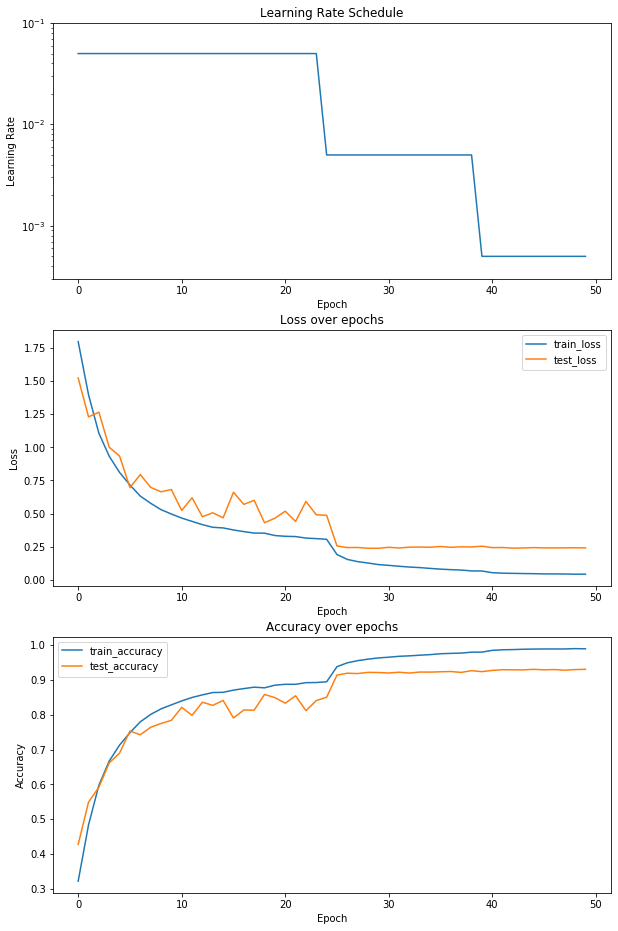

In [17]:
checkpoint = torch.load(f'{model_dir}_resnet9')
r9 = resnet9(num_classes=10, zero_init_residual=True).to(device)
r9.load_state_dict(checkpoint['model_state_dict'])
evaluate(test_ds, r9, nn.CrossEntropyLoss())
plot_history(checkpoint['history'])

In [14]:
model = resnet18(num_classes=10, zero_init_residual=True)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40, 70], gamma=0.1)
history = train(train_ds, test_ds, optimizer, model, scheduler=scheduler, epochs=100)
torch.save({
    'model_state_dict': model.state_dict(),
    'opt_state_dict': optimizer.state_dict(),
    'history': history
}, f'{model_dir}_longer_training')

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0: Loss: 1.7519854660839072 Batch Accuracy: 0.3425


  1%|          | 1/100 [01:14<2:02:08, 74.02s/it]

Test Set evaluation: Loss: 1.559061106247238 Test Accuracy: 0.4343
Epoch 1: Loss: 1.2713751231922823 Batch Accuracy: 0.53664


  2%|▏         | 2/100 [02:29<2:01:26, 74.35s/it]

Test Set evaluation: Loss: 1.2433847204039368 Test Accuracy: 0.5674
Epoch 2: Loss: 0.9884406892235017 Batch Accuracy: 0.64328


  3%|▎         | 3/100 [03:45<2:01:01, 74.86s/it]

Test Set evaluation: Loss: 1.0102956951419009 Test Accuracy: 0.6532
Epoch 3: Loss: 0.8378199968496551 Batch Accuracy: 0.70132


  4%|▍         | 4/100 [05:00<2:00:10, 75.11s/it]

Test Set evaluation: Loss: 0.9023083637032328 Test Accuracy: 0.6968
Epoch 4: Loss: 0.712366155117674 Batch Accuracy: 0.75126


  5%|▌         | 5/100 [06:15<1:58:49, 75.04s/it]

Test Set evaluation: Loss: 0.7341368013544928 Test Accuracy: 0.7456
Epoch 5: Loss: 0.6251104858982593 Batch Accuracy: 0.78362


  6%|▌         | 6/100 [07:31<1:57:46, 75.17s/it]

Test Set evaluation: Loss: 0.8497036786019048 Test Accuracy: 0.7158
Epoch 6: Loss: 0.5561190251346744 Batch Accuracy: 0.80888


  7%|▋         | 7/100 [08:46<1:56:29, 75.16s/it]

Test Set evaluation: Loss: 0.6387201223192336 Test Accuracy: 0.7814
Epoch 7: Loss: 0.5062871045621155 Batch Accuracy: 0.82518


  8%|▊         | 8/100 [10:00<1:54:57, 74.97s/it]

Test Set evaluation: Loss: 0.5784444865546648 Test Accuracy: 0.8038
Epoch 8: Loss: 0.4676399401691564 Batch Accuracy: 0.83954


  9%|▉         | 9/100 [11:16<1:53:46, 75.01s/it]

Test Set evaluation: Loss: 0.5478684015666382 Test Accuracy: 0.8181
Epoch 9: Loss: 0.4330363503045133 Batch Accuracy: 0.84976


 10%|█         | 10/100 [12:31<1:52:50, 75.23s/it]

Test Set evaluation: Loss: 0.6070060729980469 Test Accuracy: 0.8035
Epoch 10: Loss: 0.4112959780046702 Batch Accuracy: 0.85824


 11%|█         | 11/100 [13:47<1:51:36, 75.24s/it]

Test Set evaluation: Loss: 0.620492274059525 Test Accuracy: 0.7955
Epoch 11: Loss: 0.39178139474385837 Batch Accuracy: 0.8659


 12%|█▏        | 12/100 [15:01<1:50:05, 75.07s/it]

Test Set evaluation: Loss: 0.6957754783238037 Test Accuracy: 0.7828
Epoch 12: Loss: 0.3759014583609598 Batch Accuracy: 0.87016


 13%|█▎        | 13/100 [16:16<1:48:55, 75.12s/it]

Test Set evaluation: Loss: 0.5765043802653687 Test Accuracy: 0.8102
Epoch 13: Loss: 0.35735105637394254 Batch Accuracy: 0.87672


 14%|█▍        | 14/100 [17:31<1:47:35, 75.06s/it]

Test Set evaluation: Loss: 0.5087041439889353 Test Accuracy: 0.8353
Epoch 14: Loss: 0.3427250061536689 Batch Accuracy: 0.88176


 15%|█▌        | 15/100 [18:46<1:46:16, 75.02s/it]

Test Set evaluation: Loss: 0.610286046809788 Test Accuracy: 0.8069
Epoch 15: Loss: 0.3295628870539653 Batch Accuracy: 0.8873


 16%|█▌        | 16/100 [20:02<1:45:21, 75.25s/it]

Test Set evaluation: Loss: 0.4961752457709252 Test Accuracy: 0.8403
Epoch 16: Loss: 0.32014283793204273 Batch Accuracy: 0.88918


 17%|█▋        | 17/100 [21:17<1:44:02, 75.21s/it]

Test Set evaluation: Loss: 0.5324012738994405 Test Accuracy: 0.8321
Epoch 17: Loss: 0.31103830115721964 Batch Accuracy: 0.89286


 18%|█▊        | 18/100 [22:32<1:42:38, 75.10s/it]

Test Set evaluation: Loss: 0.5721191177262536 Test Accuracy: 0.8079
Epoch 26: Loss: 0.2651613169275891 Batch Accuracy: 0.90892


 27%|██▋       | 27/100 [33:47<1:31:08, 74.91s/it]

Test Set evaluation: Loss: 0.38267304616261133 Test Accuracy: 0.8728
Epoch 27: Loss: 0.26405732819567557 Batch Accuracy: 0.90896


 28%|██▊       | 28/100 [35:02<1:29:58, 74.98s/it]

Test Set evaluation: Loss: 0.4302271768639359 Test Accuracy: 0.86
Epoch 28: Loss: 0.2536815934245239 Batch Accuracy: 0.91236


 29%|██▉       | 29/100 [36:17<1:28:51, 75.09s/it]

Test Set evaluation: Loss: 0.47628836352613907 Test Accuracy: 0.8495
Epoch 29: Loss: 0.24991481029011708 Batch Accuracy: 0.91402


 30%|███       | 30/100 [37:23<1:24:25, 72.36s/it]

Test Set evaluation: Loss: 0.4288445045299168 Test Accuracy: 0.8611
Epoch 30: Loss: 0.2543102116383555 Batch Accuracy: 0.91192


 31%|███       | 31/100 [38:15<1:16:03, 66.14s/it]

Test Set evaluation: Loss: 0.40834365653086313 Test Accuracy: 0.8659
Epoch 31: Loss: 0.2498687262387227 Batch Accuracy: 0.91396


 32%|███▏      | 32/100 [39:09<1:11:02, 62.69s/it]

Test Set evaluation: Loss: 0.415821099771729 Test Accuracy: 0.8628
Epoch 32: Loss: 0.2471371270963908 Batch Accuracy: 0.91582


 33%|███▎      | 33/100 [40:02<1:06:44, 59.77s/it]

Test Set evaluation: Loss: 0.45702762958369675 Test Accuracy: 0.8552
Epoch 33: Loss: 0.23677981612475021 Batch Accuracy: 0.9184


 34%|███▍      | 34/100 [40:53<1:02:48, 57.10s/it]

Test Set evaluation: Loss: 0.5441178151323826 Test Accuracy: 0.8282
Epoch 34: Loss: 0.2378409352639447 Batch Accuracy: 0.91784


 35%|███▌      | 35/100 [41:44<59:50, 55.23s/it]  

Test Set evaluation: Loss: 0.3682836390371564 Test Accuracy: 0.8824
Epoch 35: Loss: 0.24421189281413014 Batch Accuracy: 0.91632


 36%|███▌      | 36/100 [42:36<57:56, 54.33s/it]

Test Set evaluation: Loss: 0.5382879346231871 Test Accuracy: 0.8343
Epoch 36: Loss: 0.23674438196374936 Batch Accuracy: 0.91758


 37%|███▋      | 37/100 [43:28<56:03, 53.38s/it]

Test Set evaluation: Loss: 0.3632693681158597 Test Accuracy: 0.883
Epoch 37: Loss: 0.23385528924748722 Batch Accuracy: 0.91952


 38%|███▊      | 38/100 [44:19<54:25, 52.68s/it]

Test Set evaluation: Loss: 0.5537700890740261 Test Accuracy: 0.8278
Epoch 38: Loss: 0.23110296802066477 Batch Accuracy: 0.9194


 39%|███▉      | 39/100 [45:09<52:54, 52.04s/it]

Test Set evaluation: Loss: 0.4984657251382176 Test Accuracy: 0.8414
Epoch 39: Loss: 0.22915031477008635 Batch Accuracy: 0.92174


 40%|████      | 40/100 [46:00<51:38, 51.64s/it]

Test Set evaluation: Loss: 0.4698364593182938 Test Accuracy: 0.8542
Epoch 40: Loss: 0.11964438303047434 Batch Accuracy: 0.96126


 41%|████      | 41/100 [46:51<50:34, 51.44s/it]

Test Set evaluation: Loss: 0.20642845502382592 Test Accuracy: 0.9313
Epoch 41: Loss: 0.08067566578459862 Batch Accuracy: 0.97414


 42%|████▏     | 42/100 [47:41<49:28, 51.18s/it]

Test Set evaluation: Loss: 0.205034713531974 Test Accuracy: 0.9347
Epoch 42: Loss: 0.06791131794119201 Batch Accuracy: 0.97854


 43%|████▎     | 43/100 [48:32<48:30, 51.06s/it]

Test Set evaluation: Loss: 0.20569659363997134 Test Accuracy: 0.9357
Epoch 43: Loss: 0.05713114931541102 Batch Accuracy: 0.9822


 44%|████▍     | 44/100 [49:24<47:48, 51.23s/it]

Test Set evaluation: Loss: 0.21076833678385878 Test Accuracy: 0.9356
Epoch 44: Loss: 0.05169707286359785 Batch Accuracy: 0.98386


 45%|████▌     | 45/100 [50:16<47:10, 51.47s/it]

Test Set evaluation: Loss: 0.20823511509578438 Test Accuracy: 0.9366
Epoch 45: Loss: 0.046086605931239207 Batch Accuracy: 0.9855


 46%|████▌     | 46/100 [51:07<46:09, 51.28s/it]

Test Set evaluation: Loss: 0.21387426640036739 Test Accuracy: 0.9386
Epoch 46: Loss: 0.03899370258807412 Batch Accuracy: 0.98836


 47%|████▋     | 47/100 [51:58<45:15, 51.24s/it]

Test Set evaluation: Loss: 0.21753100442546833 Test Accuracy: 0.9392
Epoch 47: Loss: 0.03681136338430864 Batch Accuracy: 0.98844


 48%|████▊     | 48/100 [52:49<44:17, 51.11s/it]

Test Set evaluation: Loss: 0.21615311267632473 Test Accuracy: 0.9399
Epoch 48: Loss: 0.0339111618988235 Batch Accuracy: 0.9896


 49%|████▉     | 49/100 [53:40<43:34, 51.26s/it]

Test Set evaluation: Loss: 0.22321907746829564 Test Accuracy: 0.9381
Epoch 49: Loss: 0.030659260146100733 Batch Accuracy: 0.99082


 50%|█████     | 50/100 [54:31<42:41, 51.23s/it]

Test Set evaluation: Loss: 0.22716705967919737 Test Accuracy: 0.9386
Epoch 50: Loss: 0.026851107720690576 Batch Accuracy: 0.9916


 51%|█████     | 51/100 [55:22<41:47, 51.18s/it]

Test Set evaluation: Loss: 0.2274871814665915 Test Accuracy: 0.9391
Epoch 51: Loss: 0.02434725977380372 Batch Accuracy: 0.9927


 52%|█████▏    | 52/100 [56:14<40:58, 51.23s/it]

Test Set evaluation: Loss: 0.22747952406164967 Test Accuracy: 0.9399
Epoch 52: Loss: 0.020823076245305903 Batch Accuracy: 0.99424


 53%|█████▎    | 53/100 [57:05<40:02, 51.11s/it]

Test Set evaluation: Loss: 0.23550441493339178 Test Accuracy: 0.9382
Epoch 53: Loss: 0.02160939513681852 Batch Accuracy: 0.9939


 54%|█████▍    | 54/100 [57:55<39:03, 50.94s/it]

Test Set evaluation: Loss: 0.23260168203070195 Test Accuracy: 0.9394
Epoch 54: Loss: 0.01964178513211515 Batch Accuracy: 0.9942


 55%|█████▌    | 55/100 [58:46<38:14, 51.00s/it]

Test Set evaluation: Loss: 0.23418519452591485 Test Accuracy: 0.9397
Epoch 55: Loss: 0.018848746098563685 Batch Accuracy: 0.99456


 56%|█████▌    | 56/100 [59:37<37:23, 51.00s/it]

Test Set evaluation: Loss: 0.25284011487530755 Test Accuracy: 0.9358
Epoch 56: Loss: 0.01669956326110722 Batch Accuracy: 0.99554


 57%|█████▋    | 57/100 [1:00:28<36:31, 50.96s/it]

Test Set evaluation: Loss: 0.24530014952149573 Test Accuracy: 0.9381
Epoch 57: Loss: 0.016090847287431854 Batch Accuracy: 0.99528


 58%|█████▊    | 58/100 [1:01:19<35:44, 51.05s/it]

Test Set evaluation: Loss: 0.2491278158901613 Test Accuracy: 0.9362
Epoch 58: Loss: 0.015323917775372009 Batch Accuracy: 0.99592


 59%|█████▉    | 59/100 [1:02:11<34:58, 51.19s/it]

Test Set evaluation: Loss: 0.25014673824174494 Test Accuracy: 0.9377
Epoch 59: Loss: 0.015165563165436468 Batch Accuracy: 0.99576


 60%|██████    | 60/100 [1:03:02<34:10, 51.26s/it]

Test Set evaluation: Loss: 0.24783100692343107 Test Accuracy: 0.9381
Epoch 60: Loss: 0.013220732931293014 Batch Accuracy: 0.9963


 61%|██████    | 61/100 [1:03:53<33:12, 51.08s/it]

Test Set evaluation: Loss: 0.25117962581070163 Test Accuracy: 0.9393
Epoch 61: Loss: 0.013531198193345343 Batch Accuracy: 0.99648


 62%|██████▏   | 62/100 [1:04:44<32:21, 51.10s/it]

Test Set evaluation: Loss: 0.25054035222605814 Test Accuracy: 0.9386
Epoch 62: Loss: 0.015033814309955672 Batch Accuracy: 0.99582


 63%|██████▎   | 63/100 [1:05:36<31:33, 51.18s/it]

Test Set evaluation: Loss: 0.2483217786950401 Test Accuracy: 0.938
Epoch 63: Loss: 0.013141524085960806 Batch Accuracy: 0.9966


 64%|██████▍   | 64/100 [1:06:28<30:54, 51.51s/it]

Test Set evaluation: Loss: 0.2528877836428111 Test Accuracy: 0.9369
Epoch 64: Loss: 0.013177784409878962 Batch Accuracy: 0.9963


 65%|██████▌   | 65/100 [1:07:20<30:07, 51.65s/it]

Test Set evaluation: Loss: 0.25070509729506096 Test Accuracy: 0.9385
Epoch 65: Loss: 0.012553222539067706 Batch Accuracy: 0.99652


 66%|██████▌   | 66/100 [1:08:11<29:11, 51.53s/it]

Test Set evaluation: Loss: 0.25191880375901354 Test Accuracy: 0.9374
Epoch 66: Loss: 0.012606494085829886 Batch Accuracy: 0.99622


 67%|██████▋   | 67/100 [1:09:03<28:24, 51.65s/it]

Test Set evaluation: Loss: 0.24941347350802603 Test Accuracy: 0.9382
Epoch 67: Loss: 0.011453458345006875 Batch Accuracy: 0.99668


 68%|██████▊   | 68/100 [1:09:54<27:23, 51.37s/it]

Test Set evaluation: Loss: 0.2575668190853505 Test Accuracy: 0.9387
Epoch 68: Loss: 0.01196965494233629 Batch Accuracy: 0.99682


 69%|██████▉   | 69/100 [1:10:45<26:30, 51.30s/it]

Test Set evaluation: Loss: 0.26037623153268535 Test Accuracy: 0.9365
Epoch 69: Loss: 0.012049384706039125 Batch Accuracy: 0.9965


 70%|███████   | 70/100 [1:11:36<25:36, 51.22s/it]

Test Set evaluation: Loss: 0.2581764314370819 Test Accuracy: 0.9373
Epoch 70: Loss: 0.009728044632922315 Batch Accuracy: 0.99758


 71%|███████   | 71/100 [1:12:27<24:45, 51.21s/it]

Test Set evaluation: Loss: 0.2446797862177408 Test Accuracy: 0.9408
Epoch 71: Loss: 0.007557502891028733 Batch Accuracy: 0.99836


 72%|███████▏  | 72/100 [1:13:18<23:53, 51.19s/it]

Test Set evaluation: Loss: 0.24416540063257458 Test Accuracy: 0.9405
Epoch 72: Loss: 0.0062212964379624045 Batch Accuracy: 0.99868


 73%|███████▎  | 73/100 [1:14:10<23:03, 51.24s/it]

Test Set evaluation: Loss: 0.24409273469561263 Test Accuracy: 0.9424
Epoch 73: Loss: 0.00611876581585311 Batch Accuracy: 0.99872


 74%|███████▍  | 74/100 [1:15:00<22:09, 51.15s/it]

Test Set evaluation: Loss: 0.24010672967267943 Test Accuracy: 0.9426
Epoch 74: Loss: 0.005846546769030202 Batch Accuracy: 0.99884


 75%|███████▌  | 75/100 [1:15:52<21:18, 51.14s/it]

Test Set evaluation: Loss: 0.2390766548393648 Test Accuracy: 0.9422
Epoch 75: Loss: 0.0059382681042025025 Batch Accuracy: 0.99886


 76%|███████▌  | 76/100 [1:16:43<20:30, 51.29s/it]

Test Set evaluation: Loss: 0.23838161431913135 Test Accuracy: 0.9435
Epoch 76: Loss: 0.005427978846513669 Batch Accuracy: 0.999


 77%|███████▋  | 77/100 [1:17:35<19:39, 51.29s/it]

Test Set evaluation: Loss: 0.2392611403159703 Test Accuracy: 0.942
Epoch 77: Loss: 0.005322860803364602 Batch Accuracy: 0.99906


 78%|███████▊  | 78/100 [1:18:26<18:46, 51.20s/it]

Test Set evaluation: Loss: 0.23915732071935375 Test Accuracy: 0.9426
Epoch 78: Loss: 0.004813794788155381 Batch Accuracy: 0.9993


 79%|███████▉  | 79/100 [1:19:16<17:49, 50.91s/it]

Test Set evaluation: Loss: 0.23991607072987134 Test Accuracy: 0.9427
Epoch 79: Loss: 0.0050321180210270156 Batch Accuracy: 0.99892


 80%|████████  | 80/100 [1:20:07<17:01, 51.07s/it]

Test Set evaluation: Loss: 0.23642962237324897 Test Accuracy: 0.943
Epoch 80: Loss: 0.00447191150285556 Batch Accuracy: 0.99924


 81%|████████  | 81/100 [1:20:58<16:09, 51.02s/it]

Test Set evaluation: Loss: 0.2392195030763934 Test Accuracy: 0.9425
Epoch 81: Loss: 0.0044469925788733775 Batch Accuracy: 0.99928


 82%|████████▏ | 82/100 [1:21:49<15:17, 50.99s/it]

Test Set evaluation: Loss: 0.23734176729487466 Test Accuracy: 0.9437
Epoch 82: Loss: 0.00429953439691154 Batch Accuracy: 0.99938


 83%|████████▎ | 83/100 [1:22:40<14:25, 50.92s/it]

Test Set evaluation: Loss: 0.23574000573422335 Test Accuracy: 0.9435
Epoch 83: Loss: 0.004096856430682647 Batch Accuracy: 0.99942


 84%|████████▍ | 84/100 [1:23:32<13:40, 51.28s/it]

Test Set evaluation: Loss: 0.2378626415340961 Test Accuracy: 0.9438
Epoch 84: Loss: 0.004191802152434883 Batch Accuracy: 0.99936


 85%|████████▌ | 85/100 [1:24:23<12:49, 51.27s/it]

Test Set evaluation: Loss: 0.24043298399523844 Test Accuracy: 0.9433
Epoch 85: Loss: 0.003933234552792071 Batch Accuracy: 0.99944


 86%|████████▌ | 86/100 [1:25:15<11:58, 51.34s/it]

Test Set evaluation: Loss: 0.23701931286273123 Test Accuracy: 0.9427
Epoch 86: Loss: 0.004197612555925032 Batch Accuracy: 0.99946


 87%|████████▋ | 87/100 [1:26:06<11:05, 51.21s/it]

Test Set evaluation: Loss: 0.2357837276745446 Test Accuracy: 0.9433
Epoch 87: Loss: 0.004268821573767411 Batch Accuracy: 0.99926


 88%|████████▊ | 88/100 [1:26:57<10:14, 51.19s/it]

Test Set evaluation: Loss: 0.23655285011929802 Test Accuracy: 0.9443
Epoch 88: Loss: 0.003979725364233603 Batch Accuracy: 0.9994


 89%|████████▉ | 89/100 [1:27:47<09:21, 51.07s/it]

Test Set evaluation: Loss: 0.240132735924253 Test Accuracy: 0.9431
Epoch 89: Loss: 0.0039814967638872505 Batch Accuracy: 0.99934


 90%|█████████ | 90/100 [1:28:38<08:30, 51.05s/it]

Test Set evaluation: Loss: 0.23715497459037393 Test Accuracy: 0.943
Epoch 90: Loss: 0.004100240448125354 Batch Accuracy: 0.99942


 91%|█████████ | 91/100 [1:29:30<07:40, 51.20s/it]

Test Set evaluation: Loss: 0.23805817160048062 Test Accuracy: 0.9438
Epoch 91: Loss: 0.0036437547778474916 Batch Accuracy: 0.99948


 92%|█████████▏| 92/100 [1:30:21<06:50, 51.25s/it]

Test Set evaluation: Loss: 0.23741163733073428 Test Accuracy: 0.9437
Epoch 92: Loss: 0.003893860560857341 Batch Accuracy: 0.99948


 93%|█████████▎| 93/100 [1:31:12<05:58, 51.15s/it]

Test Set evaluation: Loss: 0.23939703013512154 Test Accuracy: 0.9426
Epoch 93: Loss: 0.0038479782630215444 Batch Accuracy: 0.99946


 94%|█████████▍| 94/100 [1:32:03<05:06, 51.10s/it]

Test Set evaluation: Loss: 0.23663281163648714 Test Accuracy: 0.9426
Epoch 94: Loss: 0.003583507116019364 Batch Accuracy: 0.99956


 95%|█████████▌| 95/100 [1:32:54<04:15, 51.05s/it]

Test Set evaluation: Loss: 0.23793692655767065 Test Accuracy: 0.9438
Epoch 95: Loss: 0.0033491755711555463 Batch Accuracy: 0.99962


 96%|█████████▌| 96/100 [1:33:45<03:24, 51.03s/it]

Test Set evaluation: Loss: 0.23834940135667596 Test Accuracy: 0.9437
Epoch 96: Loss: 0.0037305225059032785 Batch Accuracy: 0.99948


 97%|█████████▋| 97/100 [1:34:37<02:33, 51.14s/it]

Test Set evaluation: Loss: 0.23687460575299926 Test Accuracy: 0.9436
Epoch 97: Loss: 0.0035283830846943283 Batch Accuracy: 0.99954


 98%|█████████▊| 98/100 [1:35:28<01:42, 51.08s/it]

Test Set evaluation: Loss: 0.2380559157721604 Test Accuracy: 0.9434
Epoch 98: Loss: 0.003761063701154002 Batch Accuracy: 0.99946


 99%|█████████▉| 99/100 [1:36:18<00:51, 51.01s/it]

Test Set evaluation: Loss: 0.23872471945006637 Test Accuracy: 0.9432
Epoch 99: Loss: 0.0035836023117458483 Batch Accuracy: 0.99946


100%|██████████| 100/100 [1:37:09<00:00, 58.30s/it]

Test Set evaluation: Loss: 0.23760270431071898 Test Accuracy: 0.9433


Test Set evaluation: Loss: 0.23760270431071898 Test Accuracy: 0.9433


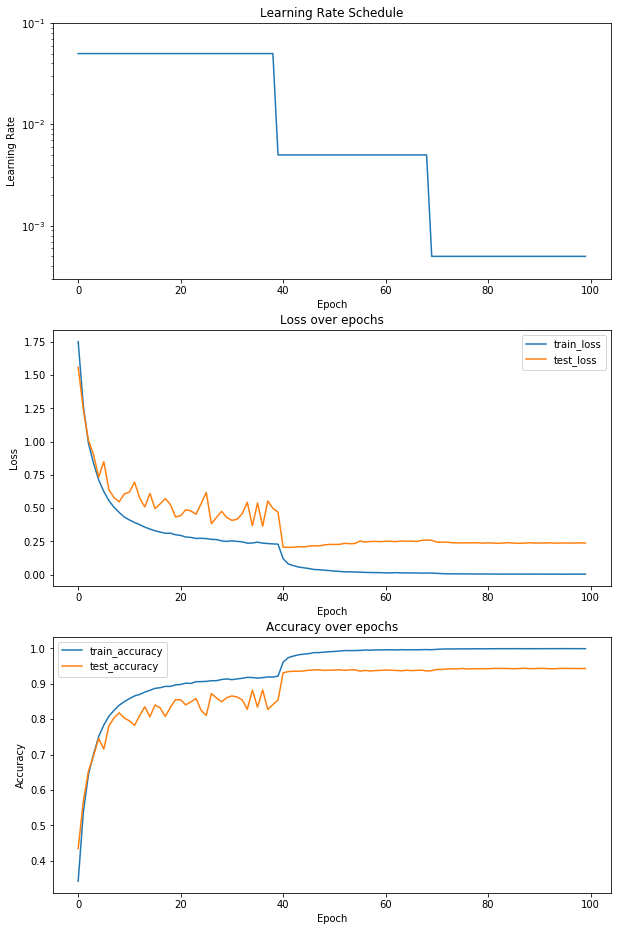

In [ ]:
checkpoint = torch.load(f'{model_dir}_longer_training')
r18_longer = resnet18(num_classes=10, zero_init_residual=True).to(device)
r18_longer.load_state_dict(checkpoint['model_state_dict'])
evaluate(test_ds, r18_longer, nn.CrossEntropyLoss())
plot_history(checkpoint['history'])